In [2]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import cv2
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime

In [4]:
class EmptyDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        return 0

    def __getitem__(self, index):
        raise IndexError("Empty dataset cannot be indexed")

In [5]:
loader = DataLoader(EmptyDataset(), batch_size=16, shuffle=False)
for i, data in enumerate(loader):
    print(i, data)

In [14]:
#store current time
date_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

In [2]:
#import resnet
resnet_model = torchvision.models.resnet18(pretrained=True)
#check number of folders in dataset folder


In [3]:
class RectAngularPadTransform(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, img):
        print(img.size)
        padding = (
            max(0, (img.size[1] - img.size[0]) // 2),
            max(0, (img.size[0] - img.size[1]) // 2)
        )
        #show image
        new_img = new_img = F.pad(img, padding)
        return new_img
    
    def __repr__(self):
        return self.__class__.__name__

In [4]:

#transform images for resnet
transform = transforms.Compose([
    RectAngularPadTransform(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
#load data
dataset = ImageFolder(root='datasets/2023-12-08-16-54', transform=transform)
targets = dataset.targets
#split data into train, test, val
#70-20-10
train_val_idx, test_idx= train_test_split(np.arange(len(targets)),test_size=0.2,shuffle=True,stratify=targets, random_state=42)
print(type(train_val_idx))
train_val_idx_list = train_val_idx.tolist()
train_val_stratifier = np.take(targets,train_val_idx_list)
#targets[train_val_idx_list]
train_idx, validation_idx = train_test_split(train_val_idx,test_size=0.125,shuffle=True,stratify=train_val_stratifier, random_state=42)
#adjust classifier to match number of classes +1 for uncertain
resnet_model.fc = nn.Linear(512, len(dataset.classes) + 1)
#load data into dataloader
batch_size = 64

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
validation_sampler = torch.utils.data.SubsetRandomSampler(validation_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=validation_sampler)

<class 'numpy.ndarray'>


In [11]:
def plot_data_loader_class_distribution(loader: DataLoader, title : str):
    #plot class distribution in dataset
    class_counts = {class_idx: 0 for class_idx in range(len(dataset.classes))}

    # Count the number of samples in each class in train dataloader
    for _, label in train_loader:
        for class_idx in label:
            print(class_idx.item())
            class_counts[class_idx.item()] += 1
    # Plot the distribution
    classes = [dataset.classes[idx] for idx in class_counts.keys()]
    counts = [class_counts[idx] for idx in class_counts.keys()]

    plot = plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
    return plot

[313, 6, 408, 73, 366, 408, 114, 216, 230]


In [ ]:
#plot class distribution in all dataloaders
date_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
plot_data_loader_class_distribution(train_loader, 'Train Data Class Distribution')
plt.savefig(f'dataset_plots/{date_time}/train_data.png')
plt.show()
plot_data_loader_class_distribution(validation_loader, 'Validation Data Class Distribution')
plt.savefig(f'dataset_plots/{date_time}/validation_data.png')
plt.show()
plot_data_loader_class_distribution(test_loader, 'Test Data Class Distribution')
plt.savefig(f'dataset_plots/{date_time}/test_data.png')
plt.show()

(2304, 3456, 3)


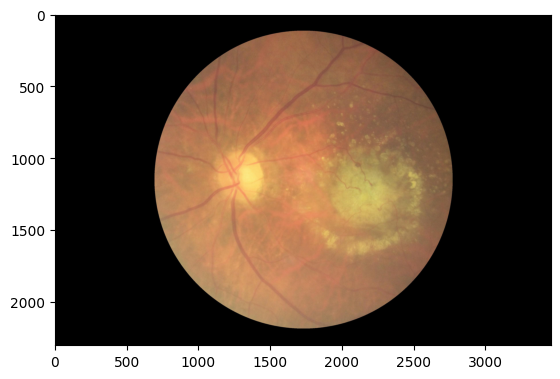

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3456, 2304)


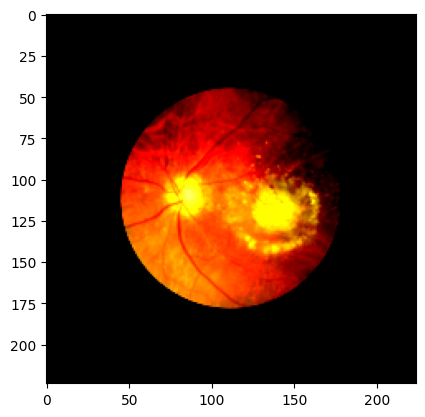

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
#plot one example with and without the transform
#pathn to example image
path = 'datasets/2023-12-07-12-57/age-related macular degeneration/43_left.jpg'
img = cv2.imread(path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img_rgb.shape)
#show image
plt.imshow(img_rgb)
plt.show()
#transform image to tensor
pil_img = Image.open(path).convert('RGB')
pil_img = transform(pil_img)
#show image
plt.imshow(pil_img.permute(1,2,0))


In [ ]:
def calculate_makro_scores(y_true, y_pred):
    #calculate precision, recall and f1 score
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    return precision_macro, recall_macro, f1_macro

def calculate_micro_scores(y_true, y_pred):
    #calculate precision, recall and f1 score
    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    return precision_micro, recall_micro, f1_micro

def calculate_scores(y_true, y_pred):
    #calculate precision, recall and f1 score
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    return precision, recall, f1

In [ ]:
#function to generate a map in which all scores can be stored
def generate_score_map():
    return {'loss': [], 'accuracy': [],
            'precision_macro': [], 'recall_macro': [], 'f1_macro': [],
            'precision_micro': [], 'recall_micro': [], 'f1_micro': [],
            'precision': [], 'recall': [], 'f1': [],
            'y_pred': [], 'y_true': [], 'time_stamp': []}

In [ ]:
train_scores = generate_score_map()
validationw_scores = generate_score_map()
test_scores = generate_score_map()

In [ ]:
#function to compute and store scores
def compute_scores(y_true, y_pred, loss, accuracy):
    y_true_np = y_true.numpy()
    y_pred_np = y_pred.numpy()
    precision_macro, recall_macro, f1_macro = calculate_makro_scores(y_true_np, y_pred_np)
    precision_micro, recall_micro, f1_micro = calculate_micro_scores(y_true_np, y_pred_np)
    precision, recall, f1 = calculate_scores(y_true_np, y_pred_np)
    return {'loss': loss, 'accuracy': accuracy, 'precision_macro': precision_macro, 'recall_macro': recall_macro, 'f1_macro': f1_macro, 'precision_micro': precision_micro, 'recall_micro': recall_micro, 'f1_micro': f1_micro, 'precision': precision, 'recall': recall, 'f1': f1, 'y_pred': y_pred_np, 'y_true': y_true_np}

#function to store the scores
def store_scores(scores, scores_dict):
    for key, value in scores.items():
        scores_dict[key].append(value)

In [ ]:
#train model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model.to(device)
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    train_loss = 0
    train_acc = 0
    resnet_model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        #forward
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #calculate loss and accuracy
        #todo fix this part or at least check if it is correct
        # train_loss += loss.item() * images.size(0)
        # ret, predictions = torch.max(outputs.data, 1)
        # correct_counts = predictions.eq(labels.data.view_as(predictions))
        # acc = torch.mean(correct_counts.type(torch.FloatTensor))
        # train_acc += acc.item() * images.size(0)
        #calculate scores
        scores = compute_scores(labels, predictions, loss.item(), acc.item())

    avg_train_loss = train_loss / len(train_loader.sampler)
    avg_train_acc = train_acc / len(train_loader.sampler)
    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f}'.format(epoch+1, avg_train_loss, avg_train_acc))

In [ ]:
#save maps as json files
import json
with open(f'scores/{date_time}/train_scores.json', 'w') as fp:
    json.dump(train_scores, fp)
with open(f'scores/{date_time}/validation_scores.json', 'w') as fp:
    json.dump(validationw_scores, fp)